# pairs_traiding

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import seaborn
from pandas_datareader import data

- 고평가 주식 매도, 저평가 주식 매수

- 재무데이터 로드['SPY'(시장행태),'AAPL'(기술),'ADBE'(기술),'LUV'(항공사),'MSFT'(기술),'SKYW'(항공),'QCOM'(기술),'HPQ'(기술),'JNPR'(기술),'AMD'(기술),'IBM'(기술)]

In [2]:
symbolsIds = ['SPY','AAPL','ADBE','LUV','MSFT',\
              'SKYW','QCOM',
                 'HPQ','JNPR','AMD','IBM']

In [3]:
def load_financial_data(symbols, start_date, end_date,output_file):
    df = data.DataReader(symbols, 'yahoo', start_date, end_date)
    return df

In [4]:
data=load_financial_data(symbolsIds,start_date='2001-01-01',
                    end_date = '2021-01-01',
                    output_file='multi_data_large.pkl')

In [6]:
# 쌍 사이의 공적분을 설정하는 함수 만들기(금융상품 리스트를 입력으로 사용해 이들 상품의 공적분 값 계산)
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.02:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

In [7]:
pvalues, pairs = find_cointegrated_pairs(data['Adj Close'])
print(pairs)

[('ADBE', 'MSFT'), ('JNPR', 'AMD'), ('JNPR', 'IBM')]


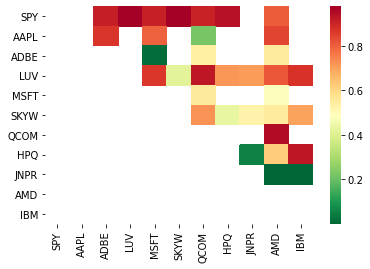

[('ADBE', 'MSFT'), ('JNPR', 'AMD'), ('JNPR', 'IBM')]


In [8]:
seaborn.heatmap(pvalues, xticklabels=symbolsIds,
                yticklabels=symbolsIds, cmap='RdYlGn_r',
                mask = (pvalues >= 0.98))
plt.show()
print (pairs)

- p값이 0.02보다 작으면 귀무가설 기각
- 2개의 가격 시계열이 공적분될 수 있음을 의미
- 두 심벌이 평균적으로 같은 스프레드를 유지한다는 것을 의미
- 빨간색이면 p값이 1 -> 귀무가설 기각x -> 한 쌍의 심벌이 공적분됐다는 유의한 증거는 없다.

- 가격의 상관관계가 0.8 이상인 자산 추려냄
- (시차=1) 자기상관계수가 0.95 이하
- 가격기준 Beta값을 공적분 계수로 활용하여 beta-1 절대값이 0.2 이하인 자산만 걸러냄
- 페어 스프레드에 대한 df검증 결과, p-value값이 0.05보다 낮은 페어만 선별

In [9]:
print(data.head(3))

Attributes  Adj Close                                                                                                                   Close                                                                                                           High                                                                                                     Low                                                                                                        Open                                                                                                      Volume                                                                                                                      
Symbols           SPY      AAPL       ADBE        LUV       MSFT       SKYW       QCOM        HPQ        JNPR      AMD        IBM         SPY      AAPL       ADBE        LUV      MSFT     SKYW      QCOM        HPQ      JNPR      AMD      IBM        SPY      AAPL     ADBE        LUV     MSFT     SKYW     QCOM

# 인위적인 심벌 쌍 만들기(아이디어 얻고자)

In [10]:
from statsmodels.tsa.stattools import coint

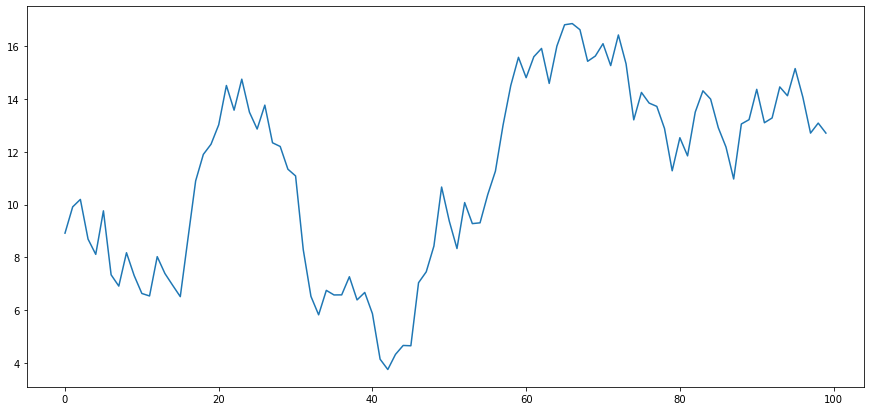

In [11]:
# 결과를 재현할 수 있도록 시드 값 설정
np.random.seed(123)

# Symbol 1의 일일 수익률을 생성
Symbol1_returns = np.random.normal(0, 1, 100)
# 종목의 주가 시리즈를 생성
Symbol1_prices = pd.Series(np.cumsum(Symbol1_returns),\
                           name='Symbol1') + 10
Symbol1_prices.plot(figsize=(15,7))
plt.show()

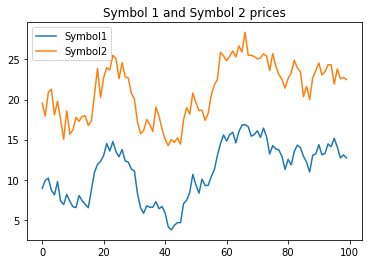

In [12]:
# 심벌 2 가격 시리즈 생성
# 심벌1 행태 복사
noise = np.random.normal(0, 1, 100)
Symbol2_prices = Symbol1_prices + 10 + noise
Symbol2_prices.name = 'Symbol2'

plt.title("Symbol 1 and Symbol 2 prices")
Symbol1_prices.plot()
Symbol2_prices.plot()
plt.legend()
plt.show()


In [13]:
score, pvalue, _ = coint(Symbol1_prices, Symbol2_prices) 
# coint함수를 사용해 두 심벌 간의 공적분을 검사, 2개의 리스트/계열 값 새영되며, 두 계열이 공적분되는지 확인하는 테스트 수행

In [14]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

# 데이터가 모집단 평균에서 얼마나 멀리 떨어져 있는지 반환, 이 반환값이 양수이면 종목 가격이 평균 가격 값보다 높음을 의미

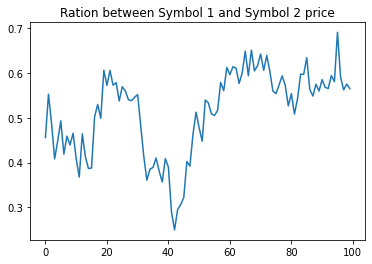

In [15]:
ratios = Symbol1_prices / Symbol2_prices
plt.title("Ration between Symbol 1 and Symbol 2 price")

ratios.plot()
plt.show()

# 두 종목 가격 사이의 비율을 사용, 주어진 가격이 평균 가격에서 멀어질 때를 정의하는 임계값 설정해야 함
# 거래하고자 하는 많은 종목이 있다면 모든 종목에 대해 분석이 수행됨

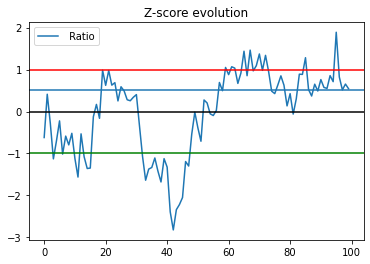

In [16]:
# train = ratios[:75]
# test = ratios[75:]

plt.axhline(ratios.mean())
plt.legend([' Ratio'])


zscore(ratios).plot()
plt.title("Z-score evolution")
plt.axhline(zscore(ratios).mean(),color="black")
plt.axhline(1.0, color="red")
plt.axhline(-1.0, color="green")
plt.show()

- z(검정) 점수의 평균은 0, z점수가 -1, 1에 도다하면 이 이벤트를 거래 시그널로 사용 (-1,1,은 임의로 정한 값)

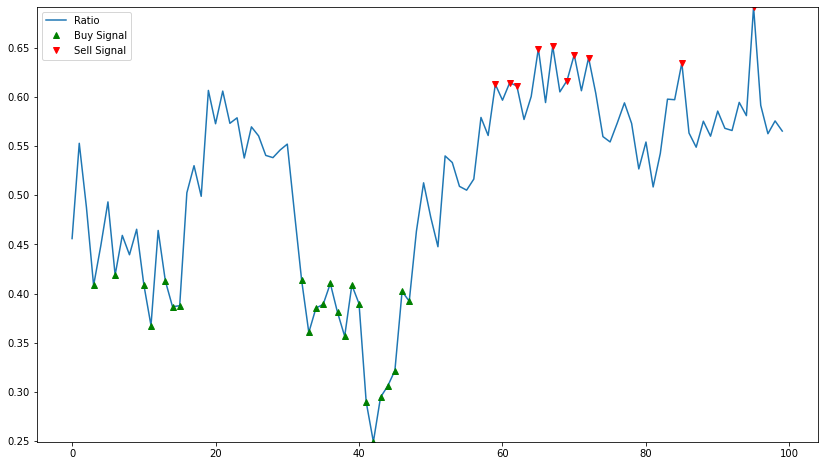

In [22]:
ratios.plot()
buy = ratios.copy()
sell = ratios.copy()
buy[zscore(ratios)>-1] = 0
sell[zscore(ratios)<1] = 0
buy.plot(color="g", linestyle="None", marker="^")
sell.plot(color="r", linestyle="None", marker="v")
x1,x2,y1,y2 = plt.axis()
# plt.rcParams["figure.figsize"] = (14,8)
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

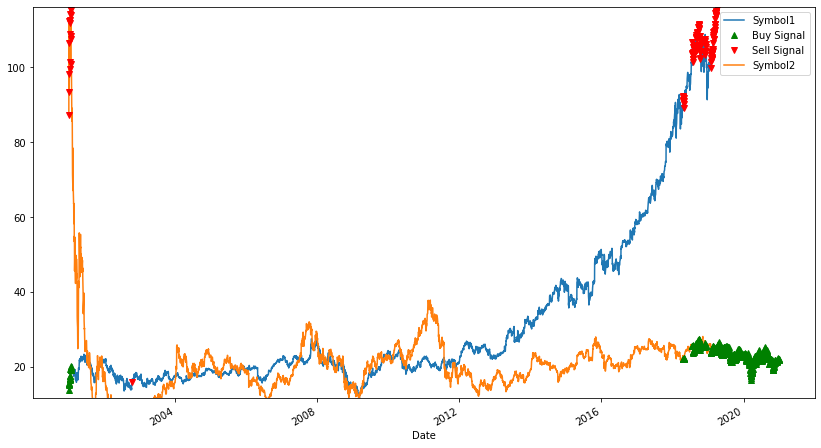

In [13]:
# 각 종목의 매수 및 매도 주문을 나타내는 코드
symbol1_buy=Symbol1_prices.copy()
symbol1_sell=Symbol1_prices.copy()
symbol2_buy=Symbol2_prices.copy()
symbol2_sell=Symbol2_prices.copy()

Symbol1_prices.plot()
symbol1_buy[zscore(ratios)>-1] = 0
symbol1_sell[zscore(ratios)<1] = 0
symbol1_buy.plot(color="g", linestyle="None", marker="^")
symbol1_sell.plot(color="r", linestyle="None", marker="v")

Symbol2_prices.plot()
symbol2_buy[zscore(ratios)<1] = 0
symbol2_sell[zscore(ratios)>-1] = 0
symbol2_buy.plot(color="g", linestyle="None", marker="^")
symbol2_sell.plot(color="r", linestyle="None", marker="v")


x1,x2,y1,y2 = plt.axis()
# plt.rcParams["figure.figsize"] = (14,8)
plt.axis((x1,x2,Symbol1_prices.min(),Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal","Symbol2"])
plt.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 실제 종목 기반 전략 구현

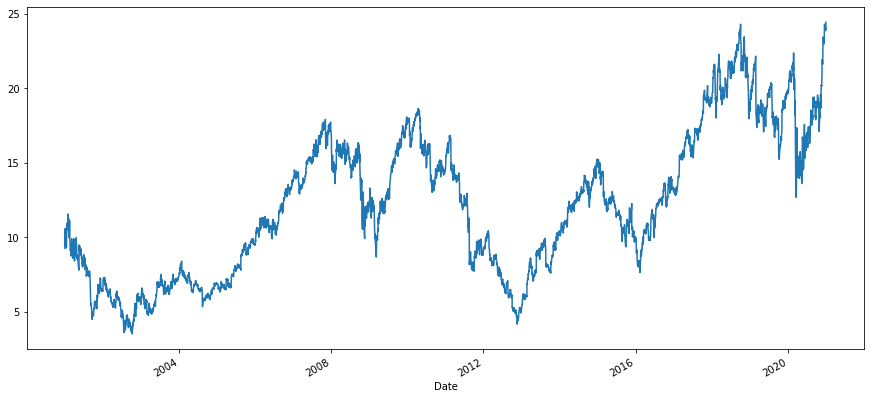

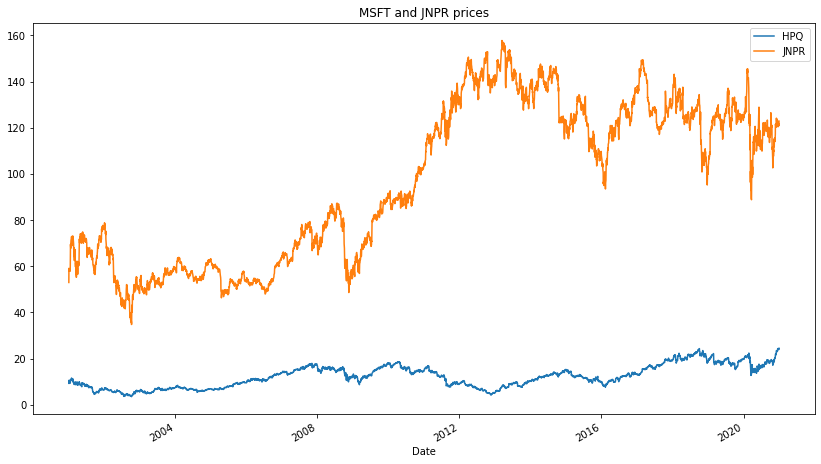

In [32]:
Symbol1_prices = data['Adj Close']['HPQ']
Symbol1_prices.plot(figsize=(15,7))
plt.show()
Symbol2_prices = data['Adj Close']['IBM']
Symbol2_prices.name = 'JNPR'
plt.title("MSFT and JNPR prices")
Symbol1_prices.plot()
Symbol2_prices.plot()
plt.legend()
plt.show()
# [('ADBE', 'MSFT'), ('JNPR', 'AMD'), ('JNPR', 'IBM')]

0.931689648653247


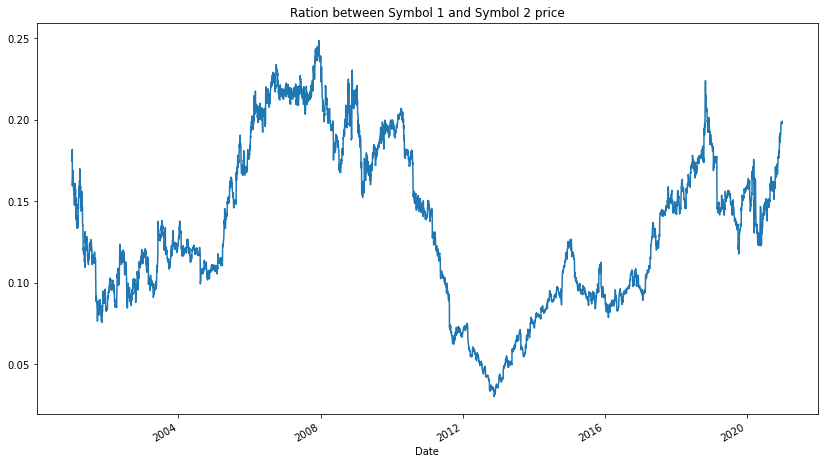

In [33]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

score, pvalue, _ = coint(Symbol1_prices, Symbol2_prices)
print(pvalue)
ratios = Symbol1_prices / Symbol2_prices
plt.title("Ration between Symbol 1 and Symbol 2 price")

ratios.plot()
plt.show()

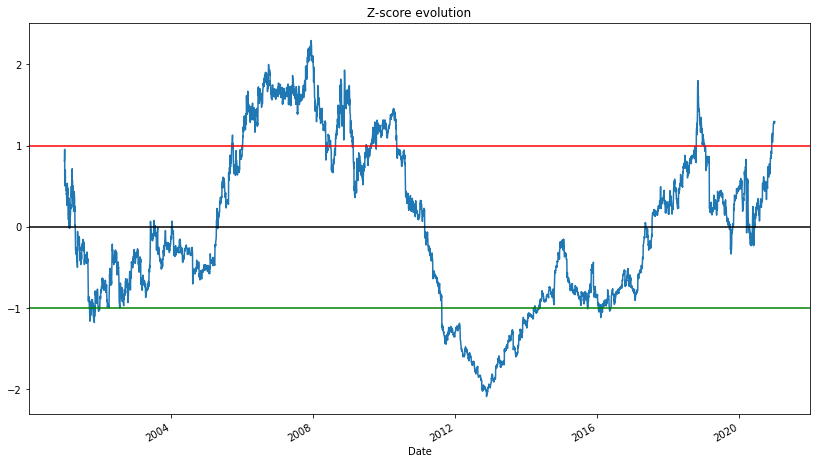

In [34]:
zscore(ratios).plot()
plt.title("Z-score evolution")
plt.axhline(zscore(ratios).mean(),color="black")
plt.axhline(1.0, color="red")
plt.axhline(-1.0, color="green")
plt.show()

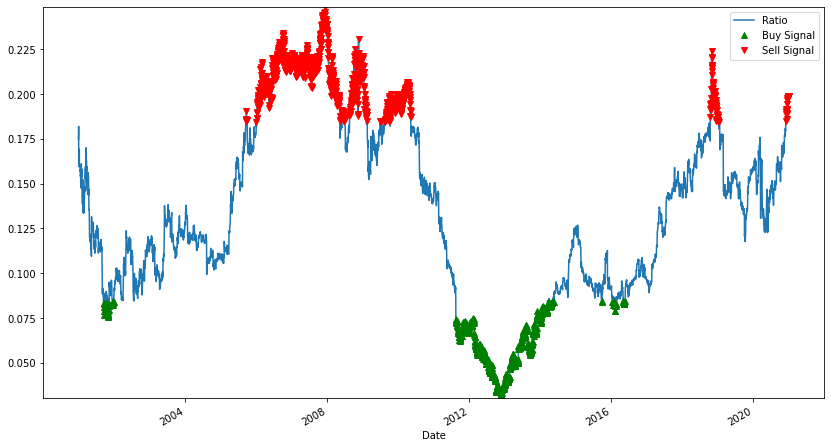

In [35]:
ratios.plot()
buy = ratios.copy()
sell = ratios.copy()
buy[zscore(ratios)>-1] = 0
sell[zscore(ratios)<1] = 0
buy.plot(color="g", linestyle="None", marker="^")
sell.plot(color="r", linestyle="None", marker="v")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(["Ratio", "Buy Signal", "Sell Signal"])
plt.show()

<AxesSubplot:xlabel='Date'>

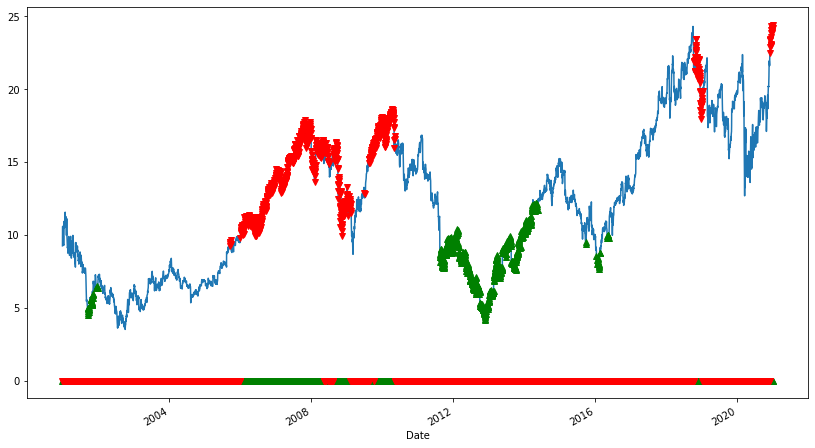

In [36]:
symbol1_buy=Symbol1_prices.copy()
symbol1_sell=Symbol1_prices.copy()
symbol2_buy=Symbol2_prices.copy()
symbol2_sell=Symbol2_prices.copy()

Symbol1_prices.plot()
symbol1_buy[zscore(ratios)>-1] = 0
symbol1_sell[zscore(ratios)<1] = 0
symbol1_buy.plot(color="g", linestyle="None", marker="^")
symbol1_sell.plot(color="r", linestyle="None", marker="v")

In [37]:
# pair_correlation_trading_strategy을 만든다. 주문 및 포지션과 관련된 정보 포함, 이걸로 이 쌍의 상관관걔 트레이딩 전략 성과 계산
pair_correlation_trading_strategy = pd.DataFrame(index=Symbol1_prices.index)
pair_correlation_trading_strategy['symbol1_price']=Symbol1_prices
pair_correlation_trading_strategy['symbol1_buy']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell']=np.zeros(len(Symbol1_prices))


In [38]:
position=0
for i in range(len(Symbol1_prices)):
    s1price=Symbol1_prices[i]
    s2price=Symbol2_prices[i]
    if not position and symbol1_buy[i]!=0:
        pair_correlation_trading_strategy['symbol1_buy'][i]=s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position=1
    elif not position and symbol1_sell[i]!=0:
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = -1
    elif position==-1 and (symbol1_sell[i]==0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1price
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2price
        position = 0
    elif position==1 and (symbol1_buy[i] == 0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1price
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2price
        position = 0

# 롱 포지션을 가질 때 매도 주문 만 허용
# 숏 포지션을 가질 때 매수 주문 만 허용
# 포지션이 없을 때 롱으로 가거나 숏으로 갈 수 있다.
# 주문 보내는 데 사용하는 가격 저장
# 상을 이루는 종목의 경우 반대를 수행
# symbol1을 매도할 때 symbol2를 매수

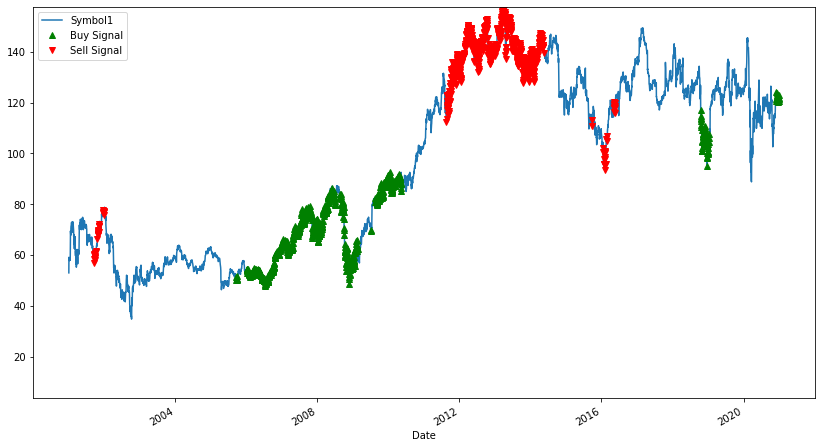

In [39]:
Symbol2_prices.plot()
symbol2_buy[zscore(ratios)<1] = 0
symbol2_sell[zscore(ratios)>-1] = 0
symbol2_buy.plot(color="g", linestyle="None", marker="^")
symbol2_sell.plot(color="r", linestyle="None", marker="v")

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,Symbol1_prices.min(),Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal","Symbol2"])
plt.show()

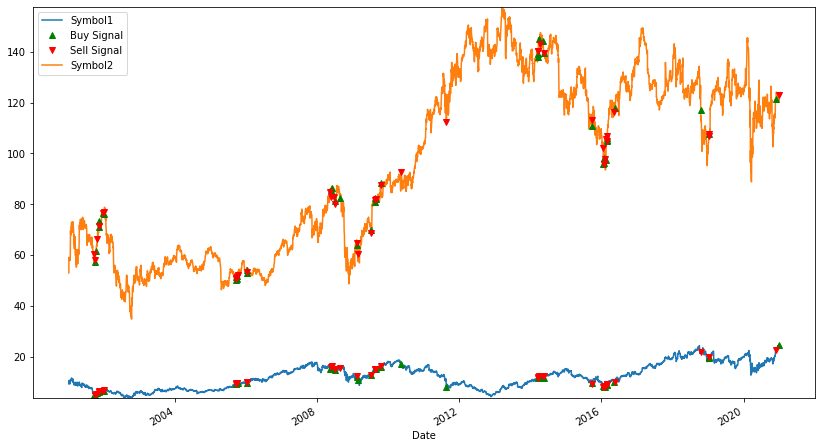

In [40]:
Symbol1_prices.plot()
pair_correlation_trading_strategy['symbol1_buy'].plot(color="g", linestyle="None", marker="^")
pair_correlation_trading_strategy['symbol1_sell'].plot(color="r", linestyle="None", marker="v")
Symbol2_prices.plot()
pair_correlation_trading_strategy['symbol2_buy'].plot(color="g", linestyle="None", marker="^")
pair_correlation_trading_strategy['symbol2_sell'].plot(color="r", linestyle="None", marker="v")
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,Symbol1_prices.min(),Symbol2_prices.max()))
plt.legend(["Symbol1", "Buy Signal", "Sell Signal","Symbol2"])
plt.show()

In [41]:
pair_correlation_trading_strategy['symbol1_buy'].head()

Date
2001-01-02    0.0
2001-01-03    0.0
2001-01-04    0.0
2001-01-05    0.0
2001-01-08    0.0
Name: symbol1_buy, dtype: float64

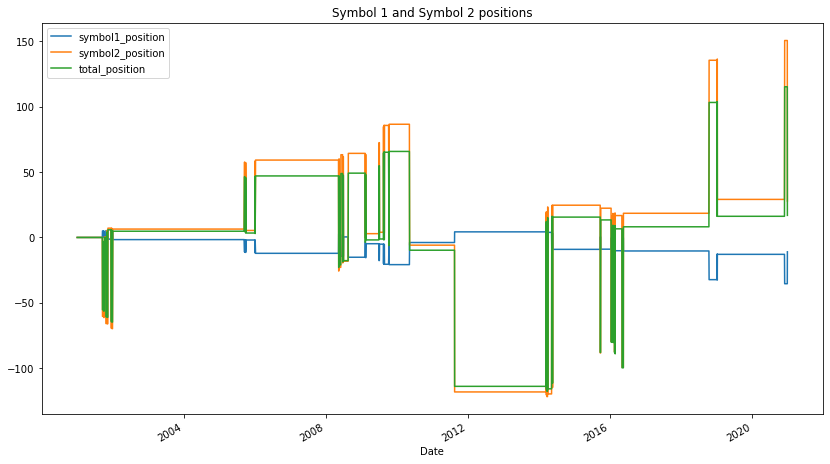

In [42]:
# 페어 상관관계 전략의 손익을 계산하는 코드 작성, symbol1과 symbol2 가격이 포함된 벡터 간의 차이를 계산 후 포지션을 추가해 손익을 나타냄
pair_correlation_trading_strategy['symbol1_position']=\
pair_correlation_trading_strategy['symbol1_buy']-pair_correlation_trading_strategy['symbol1_sell']

pair_correlation_trading_strategy['symbol2_position']=\
pair_correlation_trading_strategy['symbol2_buy']-pair_correlation_trading_strategy['symbol2_sell']

pair_correlation_trading_strategy['symbol1_position'].cumsum().plot()  # symbol1 손익
pair_correlation_trading_strategy['symbol2_position'].cumsum().plot()  # symbol2 손익

pair_correlation_trading_strategy['total_position']=\
pair_correlation_trading_strategy['symbol1_position']+pair_correlation_trading_strategy['symbol2_position']  # 손익합산
pair_correlation_trading_strategy['total_position'].cumsum().plot()
plt.title("Symbol 1 and Symbol 2 positions")
plt.legend()
plt.show()

# 파란색 선은 symbol1의 손익
# 주황색 선은 symbol2의 손익
# 녹색선은 총손익

In [43]:
pair_correlation_trading_strategy['symbol1_price']=Symbol1_prices
pair_correlation_trading_strategy['symbol1_buy']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol1_sell']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_buy']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['symbol2_sell']=np.zeros(len(Symbol1_prices))
pair_correlation_trading_strategy['delta']=np.zeros(len(Symbol1_prices))

In [44]:
position=0
s1_shares = 1000000
for i in range(len(Symbol1_prices)):
    s1positions= Symbol1_prices[i] * s1_shares
    s2positions= Symbol2_prices[i] * int(s1positions/Symbol2_prices[i])
    print(Symbol1_prices[i],Symbol2_prices[i])
    delta_position=s1positions-s2positions
    if not position and symbol1_buy[i]!=0:
        pair_correlation_trading_strategy['symbol1_buy'][i]=s1positions
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i]=delta_position
        position=1
    elif not position and symbol1_sell[i]!=0:
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2positions
        pair_correlation_trading_strategy['delta'][i] = delta_position
        position = -1
    elif position==-1 and (symbol1_sell[i]==0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_buy'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_sell'][i] = s2positions
        position = 0
    elif position==1 and (symbol1_buy[i] == 0 or i==len(Symbol1_prices)-1):
        pair_correlation_trading_strategy['symbol1_sell'][i] = s1positions
        pair_correlation_trading_strategy['symbol2_buy'][i] = s2positions
        position = 0

9.246182441711426 52.950340270996094
10.41150951385498 59.07649230957031
10.583443641662598 58.179012298583984
9.36080551147461 58.68629837036133
9.59005069732666 58.413150787353516
9.647363662719727 57.7888298034668
9.704669952392578 58.335113525390625
9.895707130432129 58.491180419921875
9.379908561706543 58.56924819946289
9.284391403198242 57.90589141845703
9.666467666625977 60.36416244506836
10.602545738220215 67.62191772460938
10.927306175231934 69.45587158203125
10.545234680175781 67.77796936035156
10.487924575805664 68.09014892578125
10.698063850402832 68.9486083984375
10.526131629943848 69.1436996459961
10.526131629943848 71.28978729248047
11.471382141113281 71.78461456298828
11.553905487060547 72.80223846435547
11.263531684875488 69.92406463623047
11.266589164733887 71.2039794921875
10.927306175231934 68.84400177001953
10.789763450622559 70.06144714355469
11.248250007629395 71.29136657714844
11.003722190856934 73.07270050048828
10.64915943145752 71.31635284423828
10.2395725250

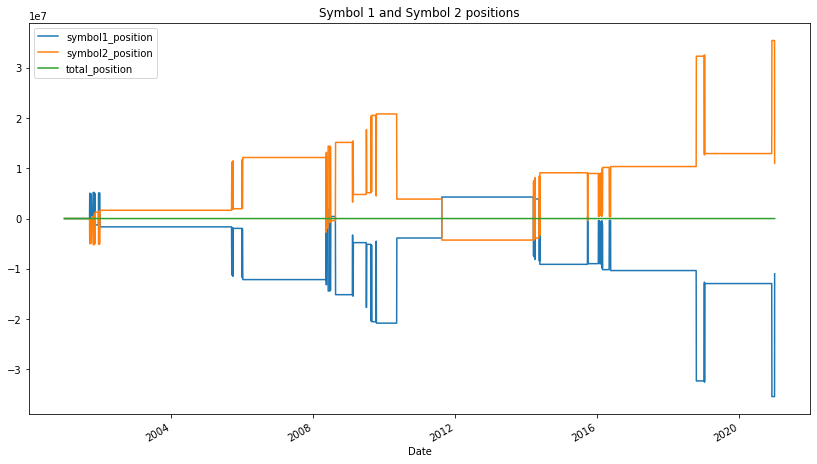

In [45]:
pair_correlation_trading_strategy['symbol1_position']=\
pair_correlation_trading_strategy['symbol1_buy']-pair_correlation_trading_strategy['symbol1_sell']

pair_correlation_trading_strategy['symbol2_position']=\
pair_correlation_trading_strategy['symbol2_buy']-pair_correlation_trading_strategy['symbol2_sell']

pair_correlation_trading_strategy['symbol1_position'].cumsum().plot()
pair_correlation_trading_strategy['symbol2_position'].cumsum().plot()

pair_correlation_trading_strategy['total_position']=\
pair_correlation_trading_strategy['symbol1_position']+pair_correlation_trading_strategy['symbol2_position']
pair_correlation_trading_strategy['total_position'].cumsum().plot()
plt.title("Symbol 1 and Symbol 2 positions")
plt.legend()
plt.show()


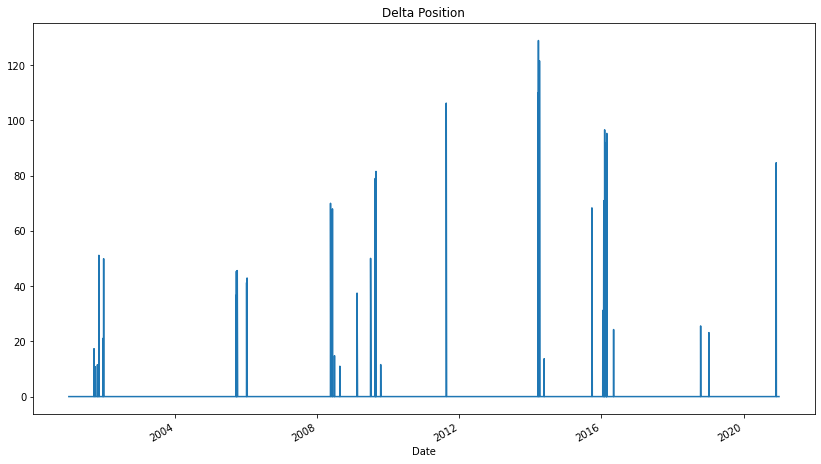

In [46]:
pair_correlation_trading_strategy['delta'].plot()
plt.title("Delta Position")
plt.show()